# Trabajo Practico - Desarrollo de software para el cálculo de parámetros acústicos ISO 3382 (1er entrega)

## Fecha de entrega

*Ingresar fecha*

## Integrantes

* <Nombre, Apellido>
* <Nombre, Apellido>
* <Nombre, Apellido>

## Aspectos generales del notebook

* Todas las funciones deben contar con su [docstring](https://realpython.com/documenting-python-code/#docstring-types), como figura en la funcion de ejemplo (`ruidoRosa_voss`).
* Todos los gráficos deben tener correctamente etiquetados los ejes.
* Enviar el notebook (.ipynb) completado y con las celdas ejecutas a myommi@untref.edu.ar.
* Todas las señales de audio deben ser grabadas en formato .wav en la misma función que las genera.

## Librerias utilizadas
Agregar todas las librerias utilizadas, algunas a modo de ejemplo:

In [1]:
import soundfile as sf
import sounddevice as sd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # Importa pyplot de matplotlib

## Función de sintetización de ruido rosa
El ruido rosa o ruido $\frac{1}{\sqrt{f}}$ , dónde $f$ denota frecuencia en Hz, es un ruido con una distribución de frecuencias tal que su densidad espectral de potencia es proporcional a la inversa de la frecuencia. Esto implica que su nivel, por bandas de tercio de octava, es constante. El nivel del ruido rosa por intervalo fijo de frecuencias va decayendo a razón de 3 dB/octava, de forma no lineal aunque las frecuencias se representan en un eje lineal.

![Espectro del ruido rosa](../img/image44.png)
<center><b>Fig 1.</b> Espectro del ruido rosa.</center>

Se adjunta a continuación una función que devuelva un ruido rosa sintetizado a partir del algoritmo de Voss y Clarke (pueden encontrar mas informacion en [este enlace](https://www.dsprelated.com/showabstract/3933.php) y en [este notebook](https://github.com/AllenDowney/ThinkDSP/blob/master/code/voss.ipynb)). 

**Consigna:** modificar la función original para que reciba como parametro la duración del ruido en segundos $t$ y como parametro opcional la frecuencia de muestreo $fs$ (Ayuda: la longitud de la señal sera el producto entre ambos). La función debe guardar el archivo de audio .wav de la señal generada y devolver el vector de datos de la señal.

In [2]:

def ruidoRosa_voss(t, fs=44100):
    """
    Genera ruido rosa utilizando el algoritmo de Voss-McCartney(https://www.dsprelated.com/showabstract/3933.php).
    
    Parametros
    ----------
    t : float
        Valor temporal en segundos, este determina la duración del ruido generado.
    fs : int, opcional
        Frecuencia de muestreo en Hz de la señal. Por defecto, el valor es 44100 Hz.
    
    returns: NumPy array
        Datos de la señal generada.
    """
    
    nrows = int(t * fs)
    ncols = 16  # Puedes ajustar el número de columnas según tus necesidades
    
    array = np.full((nrows, ncols), np.nan)
    array[0, :] = np.random.random(ncols)
    array[:, 0] = np.random.random(nrows)
    
    # el numero total de cambios es nrows
    n = nrows
    cols = np.random.geometric(0.5, n)
    cols[cols >= ncols] = 0
    rows = np.random.randint(nrows, size=n)
    array[rows, cols] = np.random.random(n)
    
    df = pd.DataFrame(array)
    filled = df.fillna(method='ffill', axis=0)
    total = filled.sum(axis=1)
    
    ## Centrado de el array en 0
    total = total - total.mean()
    
    ## Normalizado
    valor_max = max(abs(max(total)), abs(min(total)))
    total = total / valor_max
    
    # Generar el archivo de audio .wav
    sf.write('ruidoRosa.wav', total, fs)
    
    return total

Llamar la función.

In [3]:
# completar
ruido_rosa = ruidoRosa_voss(t=20, fs=44100)

Realizar una función para visualizar el dominio temporal de la señal.

In [4]:
# completar
def visualizar_dominio_temporal(senal, fs):
    """
    Visualiza el dominio temporal de una señal de audio generada.

    Parámetros:
    senal (array): El vector de datos de la señal en el dominio temporal.
    fs (int): Frecuencia de muestreo en Hz de la señal.

    """
    # Calcula el eje de tiempo en segundos
    tiempo = np.arange(0, len(senal)) / fs

    # Crea una figura y un eje
    plt.figure(figsize=(10, 4))
    plt.plot(tiempo, senal, color='b')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.title('Dominio Temporal de la Señal de Audio Generada')
    plt.grid(True)

    # Muestra la gráfica
    plt.show()

Llamar a la función.

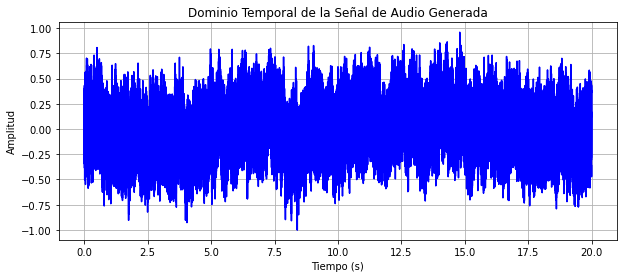

In [5]:
# completar
visualizar_dominio_temporal(ruido_rosa, fs=44100)

Graficar el dominio espectral del resultado utilizando el [software Audacity](https://www.audacityteam.org/) (Ayuda: [Plot Spectrum Audacity](https://manual.audacityteam.org/man/plot_spectrum.html))

In [43]:
# completar

Reproducir resultado.

In [6]:
# completar
sd.play(ruido_rosa)
sd.wait()


> Solo a modo de comentario, un **método alternativo** es utilizando un filtro en el siguiente [link](https://ccrma.stanford.edu/~jos/sasp/Example_Synthesis_1_F_Noise.html) se presenta la implementación en Matlab/Octave.

## Funcion de generación de sine sweep logaritmico + filtro inverso
El sine sweep es el método más indicado para generar el impulso por medio de la convolución (Nikolić, I., and O. H. Bjor, 2003). Dado que métodos tales como: explosión de globo, aplauso, disparo con pistola se salva, paper gun ([Paper Popper](https://en.wikipedia.org/wiki/Paper_popper)), golpe entre maderas, petardos, entre otros, carecen de reproducibilidad. Esto es debido a su nivel sonoro, duración y características espectrales, además de una muy baja relación señal ruido, la cual difícilmente se solucione filtrando o promediando con muchas mediciones. Comencemos por ver cómo generar el sine sweep logarítmico $x(t)$ que posee la siguiente forma:

\begin{equation}
f(x) = \sin[\theta(t)]= \sin[K (e^\frac{t}{L} - 1) ]
\tag{1}
\end{equation}

Donde:

\begin{equation}
K = \frac{T w_{1}}{R}
\end{equation}

\begin{equation}
L = \frac{T}{R}
\end{equation}

y el sweep rate $R$: 

\begin{equation}
R = \ln \left( \frac{w_{2}}{w_{1}} \right)
\tag{2}
\end{equation}

Con $w_{1}$ y $w_{2}$, las frecuencias angulares inferior y superior respectivamente, $T$ es el tiempo de duración del sine sweep en segundos (Meng, Q., 2008). Si estudiamos el espectro de la señal de la ecuación (1), se observa que no es plano, sino que disminuye a razón de -3 dB/octava, como el ruido rosa (Ver fig. 2, sup). De modo que el espectro de $x(-t)$ debe ser ajustado, aumentando en 3 dB/octava, de modo que cuando realizamos el cálculo se restaure la plenitud perfecta de la respuesta de impulso medida $h(t)$ (Farina A., 2000) (Ver fig. 2, inf).

![](../img/image43.png)
<center><b>Fig 2.</b> Espectro del sine sweep. Sine sweep logarítmico  (sup). Filtro invertido (inf).</center>


En el dominio temporal las señales del sine sweep logarítmico y el filtro inverso se comportan de la siguiente manera (Ver fig. 3). 

![](../img/image46.png)
<center><b>Fig 3.</b> Magnitud del sine sweep. Sine sweep logarítmico (sup). Filtro invertido (inf).</center>

Para generar el filtro inverso $k(t)$ del sine sweep logarítmico $x(t)$ se requiere de una modulación $m(t)$ definida por la siguiente expresión:

\begin{equation}
m(t) = \frac{w_{1}}{2\pi w(t)}
\tag{3}
\end{equation}

Obtenida de la frecuencia instantánea (dado que la amplitud cambia en función de la
frecuencia), calculada a partir de la ecuación (1):

\begin{equation}
w(t)=\frac{d[\theta (t)]}{dt}=\frac{K}{L} e^\frac{t}{L}
\tag{4}
\end{equation}
m
entonces, el filtro inverso $k(t)$ queda definido como:

\begin{equation}
k(t)=m(t)x(-t)
\tag{5}
\end{equation}

**Consigna:** realizar una función generadora de un sine sweep y su filtro inverso, a partir de las ecuaciones descriptas anteriormente, y graficar el resultado de ambos filtros, usando la función anteriormente creada. Recordar almacenar los audios. Agregar docstring que indique claramente los parametros de entrada y salida.

In [1]:
# Completar
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import sounddevice as sd

def generate_and_plot_sine_sweep(fs, T, w1, w2):
    """
    Genera un sine sweep logarítmico y su filtro inverso, guarda los archivos de audio y grafica los resultados.

    Parámetros:
    fs (int): Frecuencia de muestreo en Hz.
    T (float): Duración del sine sweep en segundos.
    w1 (float): Frecuencia angular inicial en radianes por segundo.
    w2 (float): Frecuencia angular final en radianes por segundo.
    """
    # Cálculo de K y L
    R = np.log(w2 / w1)
    K = T * w1 / R
    L = T / R

    # Generación del sine sweep
    t = np.linspace(0, T, int(fs * T), endpoint=False)
    x = np.sin(K * (np.exp(t / L) - 1))

    # Cálculo de la frecuencia instantánea w(t)
    w_t = K / L * np.exp(t / L)

    # Cálculo de la modulación m(t)
    m_t = w1 / (2 * np.pi * w_t)

    # Generación del filtro inverso k(t)
    k = m_t * x[::-1]

    # Guardar los audios como archivos WAV
    sf.write("sine_sweep.wav", x, fs)
    sf.write("filtro_inverso.wav", k, fs)

    # Graficar el resultado
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(x)
    plt.title("Sine Sweep Logarítmico")
    plt.subplot(2, 1, 2)
    plt.plot(k)
    plt.title("Filtro Inverso")
    plt.tight_layout()
    plt.show()




Llamar la función.

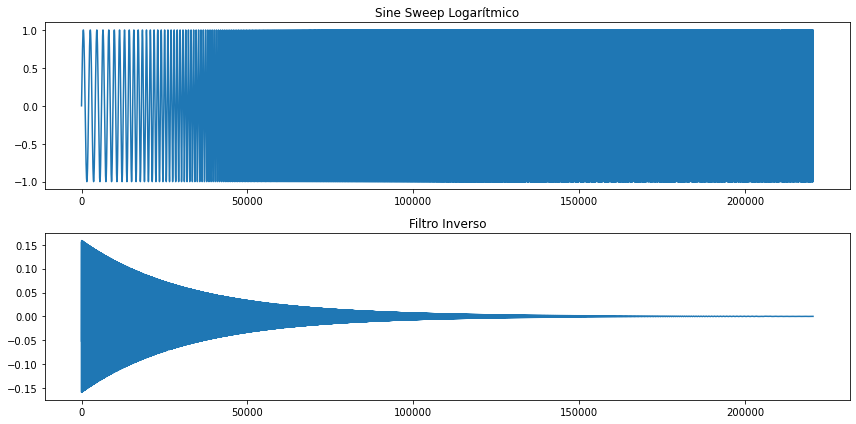

In [2]:
# completar
if __name__ == "__main__":
    # Parámetros del sine sweep
    fs = 44100  # Frecuencia de muestreo en Hz
    T = 5  # Duración del sine sweep en segundos
    w1 = 2 * np.pi * 20  # Frecuencia angular inicial en radianes por segundo
    w2 = 2 * np.pi * 20000  # Frecuencia angular final en radianes por segundo

    # Llamar a la función para generar, guardar y graficar el sine sweep y su filtro inverso
    generate_and_plot_sine_sweep(fs, T, w1, w2)

Graficar el dominio espectral del resultado utilizando el [software Audacity](https://www.audacityteam.org/) (Ayuda: [Plot Spectrum Audacity](https://manual.audacityteam.org/man/plot_spectrum.html))

In [43]:
# completar

Reproducir resultados.

In [3]:
# completar

# Nombre de los archivos de audio
sine_sweep_file = "sine_sweep.wav"
filtro_inverso_file = "filtro_inverso.wav"

# Reproducir el sine sweep
sine_sweep, fs = sf.read(sine_sweep_file)
sd.play(sine_sweep, fs)
sd.wait()  # Esperar a que termine la reproducción

# Reproducir el filtro inverso
filtro_inverso, fs = sf.read(filtro_inverso_file)
sd.play(filtro_inverso, fs)
sd.wait()  # Esperar a que termine la reproducción


## Función adquisicion y reproducción
**Consigna**: la función tiene que permitir la reproducción y la adquisición de manera simultánea para un tiempo determinado por el usuario. Es importante evaluar y constatar dicha simultaneidad. El módulo debería permitir seleccionar el hardware a utilizar. Algunos articulos de interes para el desarrollo:
* [Clase de audio](../../clases/clase_6/600_audio.ipynb)
* [Sound Device - Simultaneous Playback and Recording](https://python-sounddevice.readthedocs.io/en/0.4.1/usage.html#simultaneous-playback-and-recording)
* [Playing and Recording Sound in Python](https://realpython.com/playing-and-recording-sound-python/)
* [Audio in Python](https://wiki.python.org/moin/Audio/)
* [https://github.com/spatialaudio/python-sounddevice/issues/148](https://github.com/spatialaudio/python-sounddevice/issues/148)

In [ ]:
# Completar
import pyaudio
import wave
from pydub import AudioSegment
from pydub.playback import play

def grabar_reproducir_audio(filename, sample_format, channels, fs, seconds, chunk):
    def select_audio_device():
        p = pyaudio.PyAudio()
        devices = p.get_device_count()

        print("Dispositivos de audio disponibles:")
        for i in range(devices):
            device_info = p.get_device_info_by_index(i)
            print(f"{i}: {device_info['name']}")

        selected_device = int(input("Selecciona el número del dispositivo de entrada de audio: "))
        return selected_device

    p = pyaudio.PyAudio()
    
    # Seleccionar el dispositivo de audio
    input_device_index = select_audio_device()

    def grabar_audio(input_device_index):
        print('Iniciando grabación')
        stream = p.open(format=sample_format,
                        channels=channels,
                        rate=fs,
                        frames_per_buffer=chunk,
                        input=True,
                        input_device_index=input_device_index)

        frames = []

        for i in range(0, int(fs / chunk * seconds)):
            data = stream.read(chunk)
            frames.append(data)

        stream.stop_stream()
        stream.close()

        print('Grabación finalizada')

        wf = wave.open(filename, 'wb')
        wf.setnchannels(channels)
        wf.setsampwidth(p.get_sample_size(sample_format))
        wf.setframerate(fs)
        wf.writeframes(b''.join(frames))
        wf.close()

    def reproducir_audio(filename):
        audio = AudioSegment.from_file(filename)
        play(audio)

    # Grabar audio
    grabar_audio(input_device_index)

    # Reproducir audio
    reproducir_audio(filename)

: 

Llamar la función.

In [ ]:
# completar
# Parámetros de configuración
chunk = 1024
sample_format = pyaudio.paInt16
channels = 2
fs = 44100
seconds = 5
filename = "output.wav"
# Llamar a la función para grabar y reproducir audio
grabar_reproducir_audio(filename, sample_format, channels, fs, seconds, chunk)

¿Cómo se podría medir la latencia de la función?

In [ ]:
# Completar
import time

# Registra el tiempo de inicio
inicio_grabacion = time.time()

# Llamar a la función para grabar y reproducir audio
grabar_reproducir_audio(filename, sample_format, channels, fs, seconds, chunk)

# Registra el tiempo de finalización
fin_reproduccion = time.time()

# Calcula la latencia en segundos
latencia_segundos = fin_reproduccion - inicio_grabacion

# Convierte la latencia a milisegundos
latencia_milisegundos = latencia_segundos * 1000

print(f'Latencia de la función grabar_reproducir_audio: {latencia_milisegundos} ms')